<a href="https://colab.research.google.com/github/parkmicheal1114/Python_Quest/blob/main/DLthon/Dog_and_Cat_ResNet50_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import numpy as np
import sys
import tensorflow as tf
import os
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D , BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
import matplotlib.pyplot as plt

# Data preprocessing

In [ ]:
import zipfile

zip_paths = ['/content/drive/MyDrive/Colab Notebooks/study_dataset/dogs-vs-cats/train.zip' , '/content/drive/MyDrive/Colab Notebooks/study_dataset/dogs-vs-cats/test1.zip']  # 압축 파일의 경로와 파일명
extract_dir = './content/dogs-vs-cats/'  # 압축 해제할 폴더의 경로와 이름

for zip_path in zip_paths:
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_dir)

In [ ]:
# train 폴더 확인
train_folder_path = './content/dogs-vs-cats/train'

train_file_names = os.listdir(train_folder_path)
print("train file name" , train_file_names[:5] )
print("train file numbers" , len(train_file_names))

train file name ['cat.10600.jpg', 'cat.6545.jpg', 'cat.9254.jpg', 'dog.7384.jpg', 'cat.2704.jpg']
train file numbers 25000


In [ ]:
# test 폴더 확인
test_folder_path = './content/dogs-vs-cats/test1'

test_file_names = os.listdir(test_folder_path)
print("test file name" , test_file_names[:5] )
print("test file numbers" , len(test_file_names))

test file name ['4816.jpg', '11279.jpg', '10006.jpg', '3756.jpg', '7137.jpg']
test file numbers 12500


In [ ]:
# Train dataframe

targets = []
full_paths = []
train_cats_dir = []
train_dogs_dir = []


# Target setting
for file_name in train_file_names:
    target = file_name.split(".")[0] # target name
    full_path = os.path.join(train_folder_path, file_name)

    if(target == "dog"):
        train_dogs_dir.append(full_path)
    if(target == "cat"):
        train_cats_dir.append(full_path)

    full_paths.append(full_path)
    targets.append(target)


df_train = pd.DataFrame()
df_train['image_path'] = full_paths
df_train['target'] = targets

In [ ]:
# Test Data dataframe
full_paths = []
file_names = []

for file_name in test_file_names:
    full_path = os.path.join(test_folder_path, file_name)

    file_names.append(file_name)
    full_paths.append(full_path)


df_test = pd.DataFrame()
df_test['image_path'] = full_paths
df_test['filename'] = file_names

In [ ]:
train_data , val_data = train_test_split(df_train, test_size=0.2, random_state=123)

학습 데이터 개수  20000
검증 데이터 개수  5000


<Axes: xlabel='target', ylabel='count'>

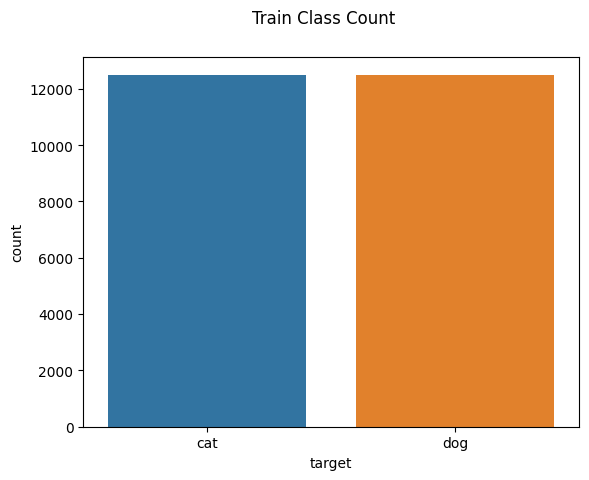

In [ ]:
import seaborn as sns
print('학습 데이터 개수 ' , len(train_data))
print('검증 데이터 개수 ' , len(val_data))

plt.suptitle('Train Class Count')
sns.countplot(data = df_train , x='target')

In [ ]:
# 테스트 parameter Initialization
batch_size = 128
epochs = 30
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input

# DataGenrator 를 사용해서 Train , Val , Test data 를 생성 하도록 한다.
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.1,
                                     horizontal_flip=True,
                                     preprocessing_function = resnet50_preprocess_input)

train_data_gen = image_gen_train.flow_from_dataframe(batch_size = batch_size,
                                                     dataframe = train_data,
                                                     x_col = 'image_path',
                                                     y_col = 'target',
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

val_datagen = ImageDataGenerator(rescale=1./255)

val_data_gen = val_datagen.flow_from_dataframe(batch_size = batch_size,
                                                     dataframe = val_data,
                                                     x_col = 'image_path',
                                                     y_col = 'target',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# Model Building

In [ ]:
# callback 선언.
from keras.callbacks import EarlyStopping , ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='min')

callbacks = [early_stopping, reduce_lr]


## ResNet50 TransferLearning  ( conv5_1 )

In [ ]:
from keras.applications import ResNet50
from keras import models, layers

# ResNet50 모델 불러오기
resnet50 = ResNet50(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), include_top=False, weights="imagenet")

# freeze_index 설정하기
freeze_index = 143 # conv5_1 레이어의 인덱스

# freeze_index 이전의 층은 고정하고, 이후의 층은 학습 가능하게 설정하기
for layer in resnet50.layers[:freeze_index]:
    layer.trainable = False
for layer in resnet50.layers[freeze_index:]:
    layer.trainable = True

# 배치 정규화 레이어는 자동 조정 적용하기
for layer in resnet50.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True

# FC Layer 추가하기
model = models.Sequential()
model.add(resnet50)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

history = model.fit(
  train_data_gen,
  steps_per_epoch= train_data.shape[0]/batch_size,
  validation_steps= val_data.shape[0]/batch_size,
  batch_size = batch_size,
  epochs=epochs,
  callbacks = callbacks,
  validation_data= val_data_gen)

94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/15
625/625 [==============================] - 531s 796ms/step - loss: 0.1410 - accuracy: 0.9707 - val_loss: 1.0484 - val_accuracy: 0.6808 - lr: 1.0000e-04
Epoch 2/15
625/625 [==============================] - 480s 767ms/step - loss: 0.0487 - accuracy: 0.9858 - val_loss: 0.2609 - val_accuracy: 0.9560 - lr: 1.0000e-04
Epoch 3/15
625/625 [==============================] - 475s 760ms/step - loss: 0.0277 - accuracy: 0.9909 - val_loss: 0.1637 - val_accuracy: 0.9706 - lr: 1.0000e-04
Epoch 4/15
298/625 [=============>................] - ETA: 3:54 - loss: 0.0251 - accuracy: 0.9942

KeyboardInterrupt: ignored

In [ ]:
model.to_save('./content/dogs-vs-cats/resnet_ver1.h5')

In [ ]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))

    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')

    axs[0].legend(['train', 'val'], loc='best')

    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')

    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(history)

NameError: ignored

In [ ]:
model.to_save('./content/dogs-vs-cats/resnet_ver2.h5')

## ResNet50 TransferLearning  ( conv4_1 )

In [ ]:
from keras.applications import ResNet50
from keras import models, layers

# ResNet50 모델 불러오기
resnet50 = ResNet50(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), include_top=False, weights="imagenet")

# freeze_index 설정하기
freeze_index = 79 # conv5_1 레이어의 인덱스

# freeze_index 이전의 층은 고정하고, 이후의 층은 학습 가능하게 설정하기
for layer in resnet50.layers[:freeze_index]:
    layer.trainable = False
for layer in resnet50.layers[freeze_index:]:
    layer.trainable = True

# 배치 정규화 레이어는 자동 조정 적용하기
for layer in resnet50.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True

# FC Layer 추가하기
model = models.Sequential()
model.add(resnet50)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

history = model.fit(
  train_data_gen,
  steps_per_epoch= train_data.shape[0]/batch_size,
  validation_steps= val_data.shape[0]/batch_size,
  batch_size = batch_size,
  epochs=epochs,
  callbacks = callbacks,
  validation_data= val_data_gen)

In [ ]:
plot_model_history(history)

# Test Data 평가

 - Label 데이터가 없어서 시각화로 표현

In [ ]:
#테스트 데이터처리.
test_datagen = ImageDataGenerator(rescale=1./255)

test_data_gen = test_datagen.flow_from_dataframe(batch_size = batch_size,
                                                     dataframe = df_test,
                                                     x_col = 'image_path',
                                                     y_col = 'target',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

In [ ]:
# 모델 예측하기
pred = model.predict(test_data_gen)

# 임계값 적용하기
predictions = (pred > 0.5).astype(int)
df_test['pred']  = predictions

In [ ]:
from PIL import Image

# test 데이터 평가.
fig = plt.figure(1, figsize=(20, 20))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(Image.open(df_test.image_path[i]))
    plt.title(f"Predicted as {'dog' if predictions[i] == 1 else 'cat'} \n Confidence : {round(100*(np.max(pred[i])), 2)}% ", fontsize=8)

plt.tight_layout
plt.show